In [1]:
# library
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.utils import resample
from matplotlib import pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

2022-12-05 17:11:38.182429: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-05 17:11:38.182647: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load cleaned data
data = pd.read_pickle("../input/fakereal-job/cleaned.pkl")

In [3]:
data

,company_profile,description,requirements,benefits,fraudulent
0,food52 weve created groundbreaking awardwinnin...,food52 fastgrowing james beard awardwinning on...,experience content management systems major pl...,experience content management systems major pl...,0
1,90 seconds worlds cloud video production servi...,organised focused vibrant awesomedo passion cu...,expect key responsibility communicate client 9...,expect key responsibility communicate client 9...,0
2,valor services provides workforce solutions me...,client located houston actively seeking experi...,implement precommissioning commissioning proce...,implement precommissioning commissioning proce...,0
3,passion improving quality life geography heart...,company esri environmental systems research in...,education bachelors masters gis business admin...,education bachelors masters gis business admin...,0
4,spot source solutions llc global human capital...,job title itemization review manager location ...,qualifications rn license state texas diploma ...,qualifications rn license state texas diploma ...,0
...,...,...,...,...,...
17875,vend looking awesome new talent come join us y...,case first time youve visited website vend awa...,ace role eat comprehensive statements work bre...,ace role eat comprehensive statements work bre...,0
17876,web linc ecommerce platform services provider ...,payroll accountant focus primarily payroll fun...,ba bs accounting desire fun love genuine passi...,ba bs accounting desire fun love genuine passi...,0
17877,provide full time permanent positions many med...,experienced project cost control staff enginee...,least 12 years professional experienceability ...,least 12 years professional experienceability ...,0
17878,na,nemsia studios looking experienced visualgraph...,1 must fluent latest versions corel amp adobe ...,1 must fluent latest versions corel amp adobe ...,0


In [4]:
# We connect all text together as one feature.
data["full_text"] = data["company_profile"] + " " + data["description"] + " " + data["requirements"] + " " + data["benefits"]

In [5]:
# Check if there has any Null value
null_all = data.isnull().sum()
print(null_all)

company_profile    0
description        0
requirements       0
benefits           0
fraudulent         0
full_text          0
dtype: int64


# Balance Data Set

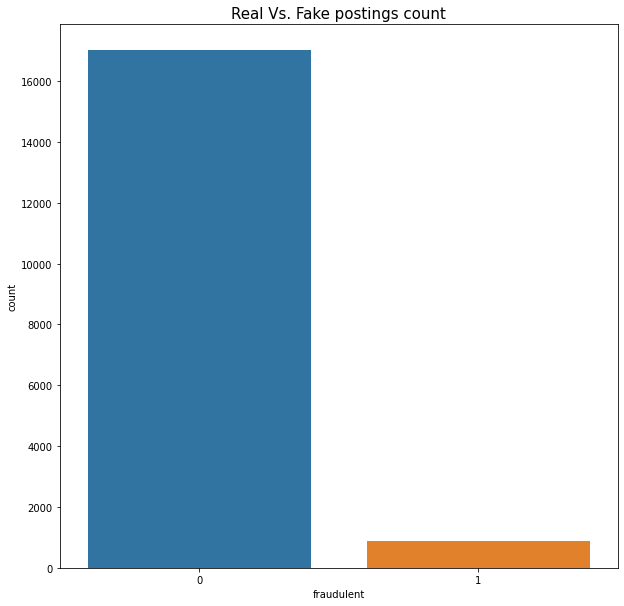

In [6]:
# Check if imbalance data by using bar figure.
plt.figure(figsize = (10,10))
sns.countplot(x="fraudulent", data=data)
plt.title("Real Vs. Fake postings count", fontsize = 15)
plt.show()

In [7]:
train, test = train_test_split(data, test_size=0.2, random_state = 1)

In [8]:
# Check imbalance data distribution.
print("Number of cases: " , len(train))
print("Number of fraudulent cases: ", len(train[train["fraudulent"] == 1]))
print("Number of non fraudulent cases: ", len(train[train["fraudulent"] == 0]))

Number of cases:  14303
Number of fraudulent cases:  708
Number of non fraudulent cases:  13595


In [9]:
# Random seed.
random.seed(1)

# Since the fraudulent cases is extremely less than non-fradulent cases, we assign non-fraudulent as majority.
df_majority = train[train["fraudulent"]== 0]
df_minority = train[train["fraudulent"]== 1]

# Upsample the dataset by simply copying records from minority classes by using resample().
# The value for the n_samples parameter is set to a half of the number of majority class to avoid overfitting.
negative_upsample = resample(df_minority, replace = True, 
                        n_samples = math.ceil(df_majority.shape[0]/2),
                        random_state = 101)

# Aslo, we need to undersample majority classes
negative_undersample = resample(df_majority, replace = True, 
                        n_samples = math.ceil(df_majority.shape[0]/2),
                        random_state = 101)

# Concat two dataframes (majority class and upsampled minority class).
df_upsampled = pd.concat([negative_undersample, negative_upsample])
df_upsampled = df_upsampled.sample(frac = 1, random_state = 101)

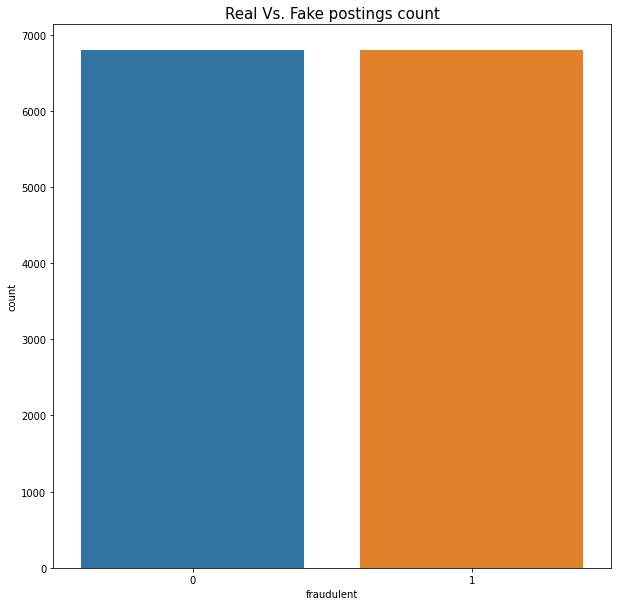

In [10]:
# Show data distribution after resample
plt.figure(figsize = (10,10))
sns.countplot(x="fraudulent", data=df_upsampled)
plt.title("Real Vs. Fake postings count", fontsize = 15)
plt.show()

In [11]:
# Check data after resample.
print("Number of cases: " , len(df_upsampled))
print("Number of fraudulent cases: ", len(df_upsampled[df_upsampled["fraudulent"] == 1]))
print("Number of non fraudulent cases: ", len(df_upsampled[df_upsampled["fraudulent"] == 0]))

Number of cases:  13596
Number of fraudulent cases:  6798
Number of non fraudulent cases:  6798


In [12]:
# Set train data as "full_text" feature and set target value.
train_x = df_upsampled['full_text']
test_x = test['full_text']

train_y = df_upsampled['fraudulent']
test_y = test['fraudulent']

# Bag of Words for Naive Bayes

In [13]:
# In this function, we count the occurrence of words and get the probabilities for the words based on the training data.
def text_counter(output_occurrence, texts, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        texts: a list of texts
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, text in zip(positive_or_negative, texts):
        split_text = text.split()
        for word in split_text:
            # Your code here
            key = (word, label)
            if key not in output_occurrence:
                output_occurrence[key] = 0
            output_occurrence[key] += 1
   
    return output_occurrence

In [14]:
# Build the freqs dictionary for later uses

freqs = text_counter({}, list(train_x), train_y)
freqs

{('professional', 0): 3187,
 ('success', 0): 1933,
 ('rapidly', 0): 598,
 ('flourishing', 0): 9,
 ('establishment', 0): 35,
 ('expanding', 0): 407,
 ('excelled', 0): 5,
 ('rate', 0): 257,
 ('allowing', 0): 101,
 ('employees', 0): 2052,
 ('opportunity', 0): 2654,
 ('grow', 0): 1352,
 ('us', 0): 4565,
 ('offer', 0): 1401,
 ('excellent', 0): 4777,
 ('advancement', 0): 177,
 ('opportunities', 0): 1934,
 ('well', 0): 3771,
 ('comfortable', 0): 880,
 ('work', 0): 16555,
 ('environmentthe', 0): 20,
 ('company', 0): 7246,
 ('built', 0): 495,
 ('market', 0): 2208,
 ('position', 0): 3458,
 ('locating', 0): 11,
 ('developing', 0): 1696,
 ('defining', 0): 142,
 ('negotiating', 0): 143,
 ('closing', 0): 697,
 ('business', 0): 9782,
 ('relations', 0): 442,
 ('significant', 0): 466,
 ('growth', 0): 2117,
 ('sales', 0): 6892,
 ('acquire', 0): 97,
 ('internet', 0): 972,
 ('department', 0): 815,
 ('proves', 0): 4,
 ('delivers', 0): 457,
 ('one', 0): 3269,
 ('live', 0): 858,
 ('chat', 0): 127,
 ('represe

In [15]:
# In this function, we find the total occurrence of a word giving information.
# We will use this function to predict the output using Naive Bayes
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    n = 0
    if (word, label) in freqs:
        n = frequency[(word, label)]
    
    return n

In [16]:
# Now we are in the training phase of the Naive Bayes algorithm. 
# In this cell, we calculate the log likelihood and log prior values for testing later.
# Also calculate the frequency of occurrence of words where the output is negative. 
# In the same way, calculate the word frequency count using the above functions.
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the texts (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] < 1:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = len(train_x)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = sum(train_y <= 0)

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = sum(train_y > 0)

    # Calculate logprior
    logprior = np.log(pos_num_docs / neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 0)
        freq_neg = find_occurrence(freqs, word, 1)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (num_pos + V)
        p_w_neg = (freq_neg + 1) / (num_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_neg / p_w_pos)


    return logprior, loglikelihood

In [17]:
# Get logprior and loglikelihood from above function. Print them to check.
logprior, loglikelihood = train_naive_bayes(freqs, list(train_x), train_y)
print(logprior)
print(len(loglikelihood))

0.0
56367


In [18]:
# It is now time to make our prediction as to whether a given text is fraudulent or not.
# After adding the log likelihood values, ensure that the output is 1 (fraudulent) if the sum of the log 
# likelihood value is greater than 0 and 0 (non-fraudulent) if the sum of the log likelihood is less than
# or equal to 0.
def naive_bayes_predict(text, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
    # process the review to get a list of words
    word_l = text.split()

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood[word]
            
    if total_prob > 0:
        total_prob = 1
    else:
        total_prob = 0
        
    return total_prob

In [19]:
# In this function, we implement the previous functions to get the predictions for the test set.
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of texts
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  
    
    y_hats = []
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(review, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.absolute(y_hats - test_y))

    accuracy = 1 - error
    
    print(confusion_matrix(test_y, y_hats))
    print("Accuracy:", accuracy)

    return accuracy, y_hats

In [20]:
# Show the confusion matrix and accuracy
print("Confusion matrix for training set:")
acc1, y_pred1 = test_naive_bayes(list(train_x), train_y, logprior, loglikelihood)
print("Confusion matrix for test set:")
acc2, y_pred2 = test_naive_bayes(list(test_x), test_y, logprior, loglikelihood)

Confusion matrix for training set:
[[6694  104]
 [  87 6711]]
Accuracy: 0.9859517505148573
Confusion matrix for test set:
[[3322   97]
 [  22  135]]
Accuracy: 0.9667225950782998


In [21]:
# Show the report of precision, recall, f1-score, and AUC.
print(classification_report(test_y, y_pred2))
print("AUC: ", roc_auc_score(test_y, y_pred2))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3419
           1       0.58      0.86      0.69       157

    accuracy                           0.97      3576
   macro avg       0.79      0.92      0.84      3576
weighted avg       0.98      0.97      0.97      3576

AUC:  0.9157508713949585


Text(0, 0.5, 'recall')

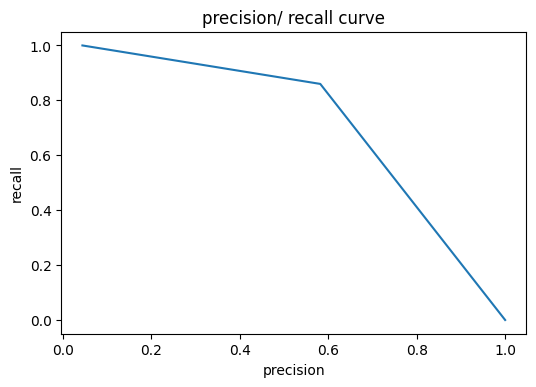

In [22]:
# The precision and recall curve
fpr, tpr, thresholds = precision_recall_curve(test_y, y_pred2)

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(fpr, tpr)
plt.title("precision/ recall curve")
plt.xlabel('precision')
plt.ylabel('recall')

Text(0, 0.5, 'tpr')

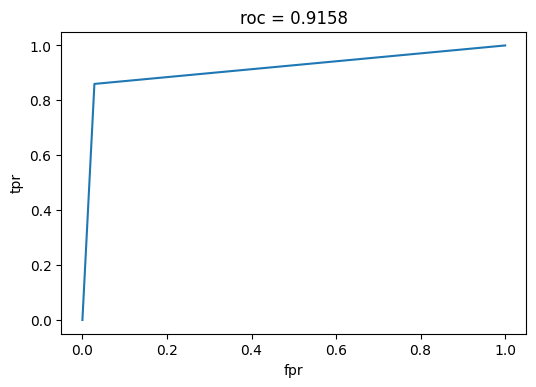

In [23]:
# The roc curve
fpr, tpr, thresholds = roc_curve(test_y, y_pred2)

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(fpr, tpr)
plt.title('roc = {:.4f}'.format(roc_auc_score(test_y, y_pred2)))
plt.xlabel('fpr')
plt.ylabel('tpr')

# Tf-idf for Multinomial Naive Bayes

In [24]:
# In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors.
# Our model cannot simply read the text data so we convert it into numerical format. 
# In order to convert the data into numerical format we create vectors from text.
vectorizer = TfidfVectorizer()

train_MNB = vectorizer.fit_transform(train_x)
test_MNB = vectorizer.transform(test_x)

In [25]:
clf = MultinomialNB(alpha=1)
clf.fit(train_MNB, train_y)
y_pred3 = clf.predict(train_MNB)
y_pred4 = clf.predict(test_MNB)

In [26]:
# Show the report of precision, recall, f1-score, and AUC.
acc3 = accuracy_score(train_y, y_pred3)
acc4 = accuracy_score(test_y, y_pred4)
print("Training accuracy:", acc3)
print("Testing accuracy:", acc4)
print(classification_report(test_y, y_pred4))
print("AUC: ", roc_auc_score(test_y, y_pred4))

Training accuracy: 0.9710944395410415
Testing accuracy: 0.9502237136465325
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3419
           1       0.46      0.87      0.61       157

    accuracy                           0.95      3576
   macro avg       0.73      0.91      0.79      3576
weighted avg       0.97      0.95      0.96      3576

AUC:  0.9131995610889317


Text(0, 0.5, 'recall')

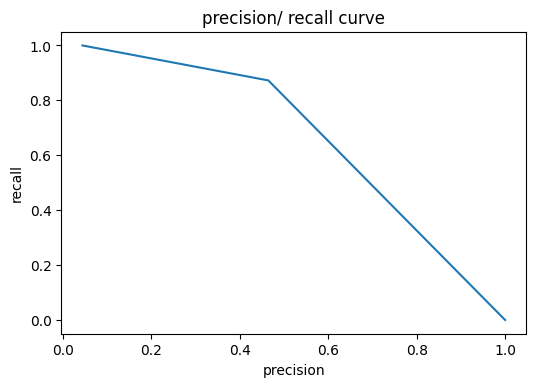

In [27]:
# The precision and recall curve
fpr, tpr, thresholds = precision_recall_curve(test_y, y_pred4)

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(fpr, tpr)
plt.title("precision/ recall curve")
plt.xlabel('precision')
plt.ylabel('recall')

Text(0, 0.5, 'tpr')

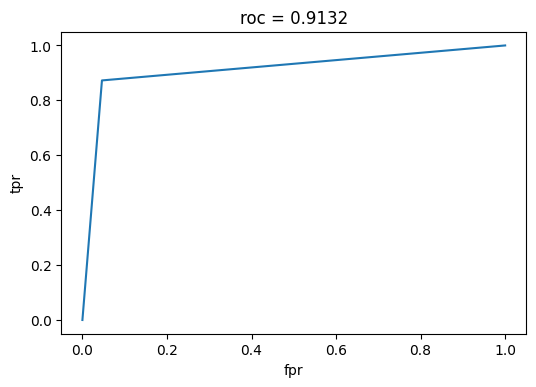

In [28]:
# The roc curve
fpr, tpr, thresholds = roc_curve(test_y, y_pred4)

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(fpr, tpr)
plt.title('roc = {:.4f}'.format(roc_auc_score(test_y, y_pred4)))
plt.xlabel('fpr')
plt.ylabel('tpr')